In [1]:
# Import required libraries
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
#from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pathlib import Path
import nltk
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import requests
import json
import time

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...


In [2]:
#Sagemaker
import os
import boto3  # AWS Python sdk
import io
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
bucket = 'project2inthenews' #'<your_s3_bucket_name_here>'

In [3]:
# Define prefix for data files
prefix = "alpaca"

# AWS IAM role
role = get_execution_role()

In [4]:
# Install Alpaca, New API, PRAW (Reddit)
!pip3 install alpaca-trade-api
import alpaca_trade_api as tradeapi

!pip3 install newsapi-python
from newsapi import NewsApiClient

!pip3 install praw
import praw

     |████████████████████████████████| 1.3 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 19.1 MB/s ta 0:00:01
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.7.4.post0
    Uninstalling aiohttp-3.7.4.post0:
      Successfully uninstalled aiohttp-3.7.4.post0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.23.4 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 176 kB 2.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/pytho

In [5]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key='d54f9f8f49c4408b8e0bc34d0f853764')

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [6]:
# Set the ticker. Please enter the ticker code e.g. TSLA or AAPL or FB
ticker = input()

# Set timeframe to '1D'
timeframe = "1D"

# Set current date and the date from the last "n" days using the ISO format. 
current_date = pd.Timestamp(datetime.now(), tz="America/New_York").isoformat()
past_date = pd.Timestamp(datetime.now()- timedelta(360), tz="America/New_York").isoformat()

# Get 4 weeks worth of historical data for the input ticker
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=past_date,
    end=current_date,
    after=None,
    until=None,
).df

# Display data for entered ticker code e.g. TSLA or FB
df.head()

 TSLA


TSLA                                      
                             open      high       low   close    volume
time                                                                   
2021-07-15 00:00:00-04:00  658.15  666.1400  637.8800  650.92  19487217
2021-07-16 00:00:00-04:00  653.49  656.6999  642.2000  644.02  15323083
2021-07-19 00:00:00-04:00  630.00  647.1999  621.2900  646.41  18988958
2021-07-20 00:00:00-04:00  651.99  662.3916  640.5010  660.31  14249603
2021-07-21 00:00:00-04:00  659.76  664.8599  650.2901  655.23  13097617

In [7]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Remove time component from index
df.index = df.index.date

# Display sample data
df.head()

,open,high,low,close,volume
2021-07-15,658.15,666.1400,637.8800,650.92,19487217
2021-07-16,653.49,656.6999,642.2000,644.02,15323083
2021-07-19,630.00,647.1999,621.2900,646.41,18988958
2021-07-20,651.99,662.3916,640.5010,660.31,14249603
2021-07-21,659.76,664.8599,650.2901,655.23,13097617


In [8]:
# Calculated percentage change in returns
df['pct_change'] = df['close'].pct_change()

# Display sample data
df.dropna(inplace=True)

# Recast index as datetime type
df.index = pd.to_datetime(df.index)
df.head()

,open,high,low,close,volume,pct_change
2021-07-16,653.49,656.6999,642.2000,644.0200,15323083,-0.010600
2021-07-19,630.00,647.1999,621.2900,646.4100,18988958,0.003711
2021-07-20,651.99,662.3916,640.5010,660.3100,14249603,0.021503
2021-07-21,659.76,664.8599,650.2901,655.2300,13097617,-0.007693
2021-07-22,656.35,662.1700,644.6001,649.1232,14317862,-0.009320


In [9]:
# DF status
df.describe()

,open,high,low,close,volume,pct_change
count,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.000000
mean,843.893889,860.889379,828.492294,845.783353,2.102485e+07,0.004931
std,178.601330,187.139237,168.830780,178.042215,1.006890e+07,0.029542
min,630.000000,647.199900,621.290000,643.320000,9.070550e+06,-0.119735
25%,711.475000,719.989950,703.320000,710.960000,1.411443e+07,-0.007266
50%,761.330000,774.800000,751.630100,774.540000,1.858836e+07,0.003711
75%,1021.165000,1064.040000,1000.825000,1024.185000,2.377608e+07,0.019935
max,1234.140000,1243.490000,1217.000000,1229.730000,6.020702e+07,0.126839


In [10]:
# Function that outputs daily news articles from NewsAPI for 30 days
# Input is keyword to search news- PLEASE ENTER THE NAME OF TICKER ABOVE e.g. tesla or facebook or apple
# Outputs a list of articles and the associated dates

past_date_news = pd.Timestamp(datetime.now()- timedelta(30), tz="America/New_York").isoformat()


def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date_news[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language="en",
            sort_by="relevancy",
            page=1,
        )
        headlines = []
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    return all_headlines, all_dates

In [11]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [12]:
# Get articles from NewsAPI for entered ticker name e.g. tesla or facebook
keyword=input()
all_headlines, dates = get_headlines(keyword)

 tesla


Fetching news about 'tesla'
******************************
retrieving news from: 2021-12-06 00:00:00
retrieving news from: 2021-12-05 00:00:00
retrieving news from: 2021-12-04 00:00:00
retrieving news from: 2021-12-03 00:00:00
retrieving news from: 2021-12-02 00:00:00
retrieving news from: 2021-12-01 00:00:00
retrieving news from: 2021-11-30 00:00:00
retrieving news from: 2021-11-29 00:00:00
retrieving news from: 2021-11-28 00:00:00
retrieving news from: 2021-11-27 00:00:00
retrieving news from: 2021-11-26 00:00:00
retrieving news from: 2021-11-25 00:00:00
retrieving news from: 2021-11-24 00:00:00
retrieving news from: 2021-11-23 00:00:00
retrieving news from: 2021-11-22 00:00:00
retrieving news from: 2021-11-21 00:00:00
retrieving news from: 2021-11-20 00:00:00
retrieving news from: 2021-11-19 00:00:00
retrieving news from: 2021-11-18 00:00:00
retrieving news from: 2021-11-17 00:00:00
retrieving news from: 2021-11-16 00:00:00
retrieving news from: 2021-11-15 00:00:00
retrieving news f

In [13]:
# Create news article dataframe
articles_dictionary = {'date': dates , 'all_headlines': all_headlines}
articles_df = pd.DataFrame(articles_dictionary)

# Initiatlise Vader sentiment analyser 
vader = SentimentIntensityAnalyzer()

# Adding extra df to change listed outputs into strings
articles_df['text_as_string'] = articles_df["all_headlines"].str[0].str.join("")
articles_df['text_as_string'].apply(lambda x: vader.polarity_scores(x)['compound'])
articles_df

,date,all_headlines,text_as_string
0,2021-12-06,[1st Fully Equipped Tesla Model Y Police Vehic...,1st Fully Equipped Tesla Model Y Police Vehicl...
1,2021-12-05,[Chinese Auto Part Maker Says Products Involve...,Chinese Auto Part Maker Says Products Involved...
2,2021-12-04,[Vingroup plans U.S. IPO for VinFast brand arm...,Vingroup plans U.S. IPO for VinFast brand arm ...
3,2021-12-03,[Elon Musk says the first Tesla Cybertruck wil...,Elon Musk says the first Tesla Cybertruck will...
4,2021-12-02,[Tesla launches electric quad bike in U.S. for...,Tesla launches electric quad bike in U.S. for ...
5,2021-12-01,[General Motors announces it will build a new ...,General Motors announces it will build a new c...
6,2021-11-30,"[Facebook, Tesla, Regeneron Pharma, ImmunoGen ...","Facebook, Tesla, Regeneron Pharma, ImmunoGen -..."
7,2021-11-29,[Elon Musk tells Tesla employees to stop rushi...,Elon Musk tells Tesla employees to stop rushin...
8,2021-11-28,[Elon Musk tells Tesla staff to cut cost of de...,Elon Musk tells Tesla staff to cut cost of del...
9,2021-11-27,[Xiaomi's upcoming EV factory will make up to ...,Xiaomi's upcoming EV factory will make up to 3...


In [14]:
analyzer = SentimentIntensityAnalyzer()

# Generating sentiment scores and putting them into the dataframe
articles_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in articles_df['text_as_string']]
articles_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in articles_df['text_as_string']]
articles_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in articles_df['text_as_string']]
articles_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in articles_df['text_as_string']]
refined_df = articles_df.drop(columns=('all_headlines')).set_index('date')

In [15]:
# Create combined dataframe for newsap and alpaca data
all_df = pd.concat([refined_df, df], axis=1)
all_df.dropna(inplace=True)
all_df

,text_as_string,compound,neg,neu,pos,open,high,low,close,volume,pct_change
2021-11-08,Twitter users tell Musk to sell Tesla shares -...,0.2960,0.000,0.784,0.216,1149.69,1197.0000,1133.00,1162.73,28835359.0,-0.048067
2021-11-09,Musk's potential Tesla stake sale follows shar...,0.2960,0.000,0.784,0.216,1173.60,1174.5000,1011.52,1023.51,57380681.0,-0.119735
2021-11-10,Bulls creep back in to Tesla options after sto...,0.0000,0.000,1.000,0.000,1010.41,1078.1000,987.31,1067.76,39110436.0,0.043234
2021-11-11,Explainer: Five legal questions raised by Elon...,0.4019,0.000,0.730,0.270,1102.77,1104.9700,1054.68,1063.51,20611963.0,-0.003980
2021-11-12,"Musk sells more Tesla stock, bringing total to...",0.0000,0.000,1.000,0.000,1047.50,1054.5000,1019.20,1033.50,23849794.0,-0.028218
2021-11-15,The Morning After: Some Tesla Superchargers ar...,0.0000,0.000,1.000,0.000,1017.63,1031.9800,978.60,1013.69,32909373.0,-0.019168
2021-11-16,JPMorgan says Tesla owes the bank $162 million,0.0000,0.000,1.000,0.000,1003.31,1057.2000,1002.18,1054.54,24663144.0,0.040298
2021-11-17,Sharp swings in EV shares draws frenzied optio...,0.2960,0.000,0.820,0.180,1063.11,1119.6400,1055.50,1089.40,29549771.0,0.033057
2021-11-18,UN to Elon Musk: Here's that $6 billion plan t...,-0.2500,0.143,0.857,0.000,1106.55,1112.0000,1075.02,1096.37,19523378.0,0.006398
2021-11-19,Tesla factory employee alleges 'rampant sexual...,-0.6597,0.435,0.565,0.000,1099.16,1138.7198,1092.70,1137.12,19639641.0,0.037168


In [16]:
# Set up model for Newsapi data
model_df = all_df.drop(columns=["neg","neu","pos","text_as_string","open", "high", "low"])
train = model_df[:int(model_df.shape[0]*0.7)]
test =  model_df[int(model_df.shape[0]*0.7):]

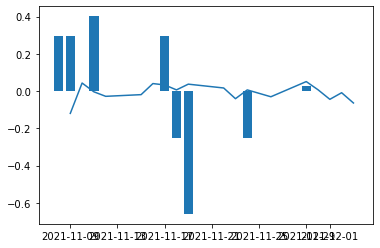

In [17]:
# Plot the compound score and percent change
barchart = plt.bar(model_df.index, model_df.compound) 
linechart = plt.plot(model_df.index, model_df.close.pct_change())

In [18]:
test

,compound,close,volume,pct_change
2021-11-26,0.0000,1081.79,10205161.0,-0.030524
2021-11-29,0.0258,1136.98,17659389.0,0.051017
2021-11-30,0.0000,1144.92,22427417.0,0.006983
2021-12-01,0.0000,1094.22,21391317.0,-0.044283
2021-12-02,0.0000,1084.53,22383901.0,-0.008856
2021-12-03,0.0000,1015.14,28779030.0,-0.063982


In [19]:
# Set up train and test data
X_train = train.drop(columns=["close", 'pct_change'])
y_train = train["pct_change"]
X_test = test.drop(columns=["close", 'pct_change'])
y_test = test["pct_change"]

In [20]:
X_test

,compound,volume
2021-11-26,0.0000,10205161.0
2021-11-29,0.0258,17659389.0
2021-11-30,0.0000,22427417.0
2021-12-01,0.0000,21391317.0
2021-12-02,0.0000,22383901.0
2021-12-03,0.0000,28779030.0


In [21]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

R2 score: -0.5782461843719218
Out-of-Sample Root Mean Squared Error (RMSE): 0.046941239466069894


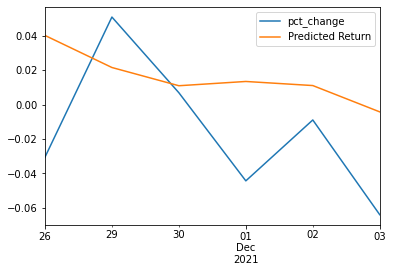

In [22]:
# Predictions and statistical analysis of model. Note the limited data set.
predictions = model.predict(X_test)
results = y_test.to_frame()
results["Predicted Return"] = predictions
results.plot()
mse = mean_squared_error(results["pct_change"], results["Predicted Return"])
rmse = np.sqrt(mse)
r2 = r2_score(results['pct_change'], results['Predicted Return'])
print(f"R2 score: {r2}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

In [23]:
# Display results
results

,pct_change,Predicted Return
2021-11-26,-0.030524,0.040323
2021-11-29,0.051017,0.021661
2021-11-30,0.006983,0.011056
2021-12-01,-0.044283,0.013537
2021-12-02,-0.008856,0.011160
2021-12-03,-0.063982,-0.004153


In [24]:
## REDDIT. This section contains the code to obtain data from Reddit using Reddit PRAW API.

In [25]:
# API keys
CLIENT_ID = 'MnLMKnyq3_YI43rKVp3_Gw'
SECRET_KEY = 'Bpvh_flU8yAJE4PdUo2Wj-S6uQx6xw'

In [26]:
# Logging into Reddit through API credentials
reddit = praw.Reddit(client_id = 'MnLMKnyq3_YI43rKVp3_Gw', 
                     client_secret = 'Bpvh_flU8yAJE4PdUo2Wj-S6uQx6xw',
                     username='MyPCIsAPotato123',
                     password='7898527412369',
                     user_agent='tutorialv1')

In [27]:
# Selecting Sub-Reddit to pull the data from
subreddit = reddit.subreddit('wallstreetbets')

In [28]:
# Reformating date input because Reddit API required 'YYYY-MM-DD'
current_date_reddit = current_date[:10]
past_date_reddit = past_date[:10]
print(current_date_reddit, past_date_reddit)

2021-12-06 2020-12-11


In [29]:
# Creating empty df to store reddit API data
reddit_df = pd.DataFrame()

# Search through subreddit for ticker, default limit for free Reddit account is 250 posts
# Then append results into dataframe
for submission in subreddit.search(ticker, limit=250):
    reddit_df = reddit_df.append({'time': submission.created_utc,
                                  'title': submission.title,
                                  'body': submission.selftext}, ignore_index=True)
    
reddit_df.head()

,body,time,title
0,How I plan to **Short Tesla ($TSLA)** with a m...,1.635530e+09,💸 $1 Million Dollar Tesla Short ($TSLA) 📉
1,,1.636823e+09,"Thanks to $TSLA, I’m buying a new wife for Chr..."
2,,1.638550e+09,I just dropped $420K on 850 $TSLA calls and FD...
3,,1.635873e+09,Holding TSLA for almost 10 years. When do I ge...
4,,1.636230e+09,My lifesavings are in TSLA please don't Elon🙏🏼


In [30]:
print(reddit_df['time'])

0      1.635530e+09
1      1.636823e+09
2      1.638550e+09
3      1.635873e+09
4      1.636230e+09
           ...     
243    1.627676e+09
244    1.612320e+09
245    1.632769e+09
246    1.634620e+09
247    1.635827e+09
Name: time, Length: 248, dtype: float64


In [31]:
# Returned time data is in unix format by default, change to standard format YYY-MM-DD HH:MM:SS
reddit_df['time'] = reddit_df['time'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
print(reddit_df['time'])

0      2021-10-29
1      2021-11-13
2      2021-12-03
3      2021-11-02
4      2021-11-06
          ...    
243    2021-07-30
244    2021-02-03
245    2021-09-27
246    2021-10-19
247    2021-11-02
Name: time, Length: 248, dtype: object


In [32]:
# Re-organise columns to make it easier to read
reddit_df = reddit_df[['time', 'title', 'body']]
reddit_df

,time,title,body
0,2021-10-29,💸 $1 Million Dollar Tesla Short ($TSLA) 📉,How I plan to **Short Tesla ($TSLA)** with a m...
1,2021-11-13,"Thanks to $TSLA, I’m buying a new wife for Chr...",
2,2021-12-03,I just dropped $420K on 850 $TSLA calls and FD...,
3,2021-11-02,Holding TSLA for almost 10 years. When do I ge...,
4,2021-11-06,My lifesavings are in TSLA please don't Elon🙏🏼,
...,...,...,...
243,2021-07-30,TSLA 10K gainz using my scholarship money,
244,2021-02-03,Message from a TSLA veteran: Shut the fuck up ...,Every other comment right now is a shill lamen...
245,2021-09-27,TSLA looking to nut?🦧🍿,
246,2021-10-19,$TSLA position going into Q3 earnings,


In [33]:
# Sort df with respect to time
reddit_df = reddit_df.sort_values(by='time', ascending=False).reset_index(drop=True)
reddit_df

,time,title,body
0,2021-12-06,"TSLA another bull flag, bet on the bounce? Or ...",
1,2021-12-05,TSLA Double top and a long way to go to the SM...,
2,2021-12-04,"Fuck it, I'm all in on TSLA. Elon better banan...",
3,2021-12-04,Lose 99% of my savings to $TSLA call,
4,2021-12-04,"TSLA apes saw this, right? Elon Musk's big Tes...",
...,...,...,...
243,2021-06-25,TSLA bought before end of day yesterday. Sold ...,
244,2021-06-20,$TSLA Chart - Anyone Else Notice This?,
245,2021-05-17,Michael Burry Reals 530 Million Bet Against TSLA,
246,2021-05-14,Let's revive the buried WSB culture! GME to TH...,"&#x200B;\n\n[The GME thesis, which I aim to ex..."


In [34]:
# Initialize vader sentiment model- check maybe duplicate
analyzer = SentimentIntensityAnalyzer()

In [35]:
# Preparing model, apply VADER sentiment, calculate sentiment scores, then append results
title = {
    "compound": [],
    "pos": [],
    "neu": [],
    "neg": [],
}

for index, row in reddit_df.iterrows():
    try:
        title_sentiment = analyzer.polarity_scores(row['title'])
        title['compound'].append(title_sentiment['compound'])
        title['pos'].append(title_sentiment['pos'])
        title['neu'].append(title_sentiment['neu'])
        title['neg'].append(title_sentiment['neg'])
        
    except AtributeError:
        pass

In [36]:
# Reformat VADER results into a dataframe
title_sentiment_df = pd.DataFrame(title)

# Join VADER results df with the original reddit df 
combined_df = reddit_df.join(title_sentiment_df)

# Ensure the data type of 'time' column is set to datetime

combined_df['time'] = pd.to_datetime(combined_df['time'])
combined_df.head()

,time,title,body,compound,pos,neu,neg
0,2021-12-06,"TSLA another bull flag, bet on the bounce? Or ...",,0.0000,0.000,1.000,0.000
1,2021-12-05,TSLA Double top and a long way to go to the SM...,,0.5719,0.281,0.719,0.000
2,2021-12-04,"Fuck it, I'm all in on TSLA. Elon better banan...",,-0.2244,0.094,0.782,0.124
3,2021-12-04,Lose 99% of my savings to $TSLA call,,-0.4019,0.000,0.722,0.278
4,2021-12-04,"TSLA apes saw this, right? Elon Musk's big Tes...",,0.0000,0.000,1.000,0.000


In [37]:
# combined dataframe
combined_df = combined_df.set_index('time')
combined_df

,title,body,compound,pos,neu,neg
time,,,,,,
2021-12-06,"TSLA another bull flag, bet on the bounce? Or ...",,0.0000,0.000,1.000,0.000
2021-12-05,TSLA Double top and a long way to go to the SM...,,0.5719,0.281,0.719,0.000
2021-12-04,"Fuck it, I'm all in on TSLA. Elon better banan...",,-0.2244,0.094,0.782,0.124
2021-12-04,Lose 99% of my savings to $TSLA call,,-0.4019,0.000,0.722,0.278
2021-12-04,"TSLA apes saw this, right? Elon Musk's big Tes...",,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...
2021-06-25,TSLA bought before end of day yesterday. Sold ...,,0.5267,0.254,0.746,0.000
2021-06-20,$TSLA Chart - Anyone Else Notice This?,,0.0000,0.000,1.000,0.000
2021-05-17,Michael Burry Reals 530 Million Bet Against TSLA,,0.0000,0.000,1.000,0.000


In [38]:
# Averaging the scores within a day if there are multiple posts within a day
daily_compound_df = pd.DataFrame(combined_df.compound.resample('D').mean())

# Dropna then sort index 
daily_compound_df = daily_compound_df.dropna().sort_index(ascending=False)
daily_compound_df

,compound
time,
2021-12-06,0.000000
2021-12-05,0.571900
2021-12-04,-0.208767
2021-12-03,0.000000
2021-12-02,0.295700
...,...
2021-06-25,0.526700
2021-06-20,0.000000
2021-05-17,0.000000


In [39]:
# Ensure the period analysed matched with what stated initally
period_compound_df = daily_compound_df
period_compound_df

,compound
time,
2021-12-06,0.000000
2021-12-05,0.571900
2021-12-04,-0.208767
2021-12-03,0.000000
2021-12-02,0.295700
...,...
2021-06-25,0.526700
2021-06-20,0.000000
2021-05-17,0.000000


In [40]:
# Combined Reddit and Alpaca dataframes
red_df = pd.concat([period_compound_df, df],axis=1)

In [41]:
red_df.tail(20)

,compound,open,high,low,close,volume,pct_change
2021-11-14,0.440400,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-15,0.383900,1017.63,1031.9800,978.60,1013.69,32909373.0,-0.019168
2021-11-16,0.055200,1003.31,1057.2000,1002.18,1054.54,24663144.0,0.040298
2021-11-17,0.318200,1063.11,1119.6400,1055.50,1089.40,29549771.0,0.033057
2021-11-18,0.000000,1106.55,1112.0000,1075.02,1096.37,19523378.0,0.006398
2021-11-19,NaN,1099.16,1138.7198,1092.70,1137.12,19639641.0,0.037168
2021-11-20,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-21,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22,0.881400,1162.01,1201.9500,1132.43,1156.05,30542562.0,0.016647
2021-11-23,0.201767,1167.51,1180.4999,1062.70,1108.81,34397054.0,-0.040863


In [42]:
## Twitter. This section contains the code to obtain data from using Twitter API.

In [43]:
# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = "AAAAAAAAAAAAAAAAAAAAAIRkWAEAAAAAbPORFUD3DCXV0sIL6MZarntBzvo%3D9T3lMXfMxlENqNpZ45j4xdqTgCC9c6BjZ7CdC3K2VZglNRK9Nv"

search_url = "https://api.twitter.com/2/tweets/search/recent"

now = datetime.now()
notnow = now - timedelta(days=1)

In [44]:
# Define function to get tweets
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [45]:
print(ticker)

TSLA


In [46]:
# Get tweets
now = datetime.utcnow()
now = now - timedelta(minutes=1)
json_responses = []
for i in range(0, 7):
    day = now - timedelta(days=i)
    print(day.isoformat())
    query_params = {'query': f"#{ticker}",
                    'tweet.fields': 'created_at,lang',
                    'max_results': 100,
                    'end_time': day.isoformat() + 'Z'
                    }
    json_responses.append(connect_to_endpoint(search_url, query_params))
    time.sleep(1)

2021-12-06T04:38:44.893487
200
2021-12-05T04:38:44.893487
200
2021-12-04T04:38:44.893487
200
2021-12-03T04:38:44.893487
200
2021-12-02T04:38:44.893487
200
2021-12-01T04:38:44.893487
200
2021-11-30T04:38:44.893487
200


In [47]:
# Set up blank list
texts = []

In [48]:
# Create dataframe for Twitter tweets
dates_formatted = []
for i, response in enumerate(json_responses):
    data = response["data"]
    for j in range(0, len(data)):
        if data[j]["lang"] == 'en':
            dates_formatted.append((pd.to_datetime(data[j]["created_at"], infer_datetime_format=True) - timedelta(hours=5)))
            
            texts.append(data[j]["text"])

twitter_df = pd.DataFrame({"Date": dates_formatted,
                  "Text": texts})

twitter_df

,Date,Text
0,2021-12-05 23:31:05+00:00,"In between NOW and 2022-12-02 ,highest CLOSE p..."
1,2021-12-05 23:31:05+00:00,"$TSLA 2021-12-03 , CLOSE PRICE = 1014.969971 #..."
2,2021-12-05 23:31:03+00:00,$TSLA last 15 days TREND #tsla #time https://t...
3,2021-12-05 23:30:59+00:00,"RT @guru_profit: Hey guys, would you dump @App..."
4,2021-12-05 23:13:02+00:00,@elonmusk Just a thought. What will you do if ...
...,...,...
487,2021-11-29 18:53:47+00:00,Tesla..What Can You Say!! #tesla #tsla #stock ...
488,2021-11-29 18:53:44+00:00,$TSLA over 1142 has plenty of room to 1165 \n✅...
489,2021-11-29 18:36:53+00:00,@Robert46989257 @BP_Rising #TSLA is the mother...
490,2021-11-29 18:34:09+00:00,RT @warrior16win: $NXMH @NextMeats_NA #SPAC Co...


In [49]:
# Calculate Twitter sentiment and 
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# twitter_df = df #pd.read_csv("tweets.csv", index_col="Date")
# twitter_df
# df.index = pd.to_datetime(df.index, format="%Y-%m-%d-%H-%M-%S")

In [50]:
# Calculate Twitter sentiment scores
analyzer = SentimentIntensityAnalyzer()
twitter_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in twitter_df['Text']]
twitter_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in twitter_df['Text']]
twitter_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in twitter_df['Text']]
twitter_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in twitter_df['Text']]
twitter_df.sample(100)

,Date,Text,compound,neg,neu,pos
106,2021-12-04 19:35:34+00:00,RT @HUMBL_Monkey: 90’s BaBYyyy !! 💙 @nickcarte...,0.0000,0.000,1.000,0.000
303,2021-12-01 20:02:44+00:00,Serious breaking news (@SawyerMerritt do your ...,-0.1511,0.069,0.901,0.031
195,2021-12-02 22:29:47+00:00,"@elonmusk green on financial sectors, red on t...",0.0000,0.000,1.000,0.000
318,2021-12-01 17:52:01+00:00,@WatcherGuru @DogelonMars He can predict the f...,0.0000,0.000,1.000,0.000
254,2021-12-02 16:12:15+00:00,"RT @GailAlfarATX: so many beautiful details, i...",0.8473,0.000,0.647,0.353
...,...,...,...,...,...,...
182,2021-12-03 18:44:13+00:00,"@stevenmarkryan #TSLA, #SpaceX ipo! And the n...",0.0000,0.000,1.000,0.000
172,2021-12-03 19:37:44+00:00,@elonmusk @Kristennetten @MinimalDuck @LudaLis...,0.0000,0.000,1.000,0.000
114,2021-12-03 23:23:09+00:00,RT @JulianMI2: How does #ARK implode? Most new...,-0.3818,0.098,0.902,0.000
4,2021-12-05 23:13:02+00:00,@elonmusk Just a thought. What will you do if ...,0.5927,0.000,0.926,0.074


In [51]:
# Combine TWitter sentiment score with stock volume and pct_change
twitter_df.index = pd.to_datetime(twitter_df.index)
twitter_df = pd.DataFrame(twitter_df.groupby(twitter_df.index).mean())
twitter_df.head()
red_df
red_df = red_df["2021-July-15":]
red_df.fillna(0)

,compound,open,high,low,close,volume,pct_change
2021-07-16,0.000000,653.49,656.6999,642.200,644.02,15323083.0,-0.010600
2021-07-17,-0.273200,0.00,0.0000,0.000,0.00,0.0,0.000000
2021-07-18,0.000000,0.00,0.0000,0.000,0.00,0.0,0.000000
2021-07-19,0.000000,630.00,647.1999,621.290,646.41,18988958.0,0.003711
2021-07-20,0.000000,651.99,662.3916,640.501,660.31,14249603.0,0.021503
...,...,...,...,...,...,...,...
2021-12-02,0.295700,1100.01,1113.0000,1056.650,1084.53,22383901.0,-0.008856
2021-12-03,0.000000,1084.45,1090.5753,1000.210,1015.14,28779030.0,-0.063982
2021-12-04,-0.208767,0.00,0.0000,0.000,0.00,0.0,0.000000
2021-12-05,0.571900,0.00,0.0000,0.000,0.00,0.0,0.000000


In [52]:
# Create combined sentiment dataframe
tw_df = pd.DataFrame({"Twitter compound": twitter_df["compound"]})
newsAPI_df = pd.DataFrame({"NewsAPI compound": all_df["compound"]})
reddit_df = pd.DataFrame({"Reddit compound": red_df["compound"]})
reddit_df = reddit_df.fillna(0)

newsAPI_df
compounds_df = pd.concat([tw_df, reddit_df, newsAPI_df],axis=1)
# compounds_df.index = pd.to_datetime(compounds_df.index)
compounds_df = compounds_df.fillna(0)
compounds_df["average"] = (compounds_df["Twitter compound"] + compounds_df["Reddit compound"] + compounds_df["NewsAPI compound"]) / 3
compounds_df

,Twitter compound,Reddit compound,NewsAPI compound,average
1970-01-01 00:00:00.000000000,-0.4648,0.000000,0.0,-0.154933
1970-01-01 00:00:00.000000001,0.0000,0.000000,0.0,0.000000
1970-01-01 00:00:00.000000002,0.0000,0.000000,0.0,0.000000
1970-01-01 00:00:00.000000003,-0.3818,0.000000,0.0,-0.127267
1970-01-01 00:00:00.000000004,0.5927,0.000000,0.0,0.197567
...,...,...,...,...
2021-12-02 00:00:00.000000000,0.0000,0.295700,0.0,0.098567
2021-12-03 00:00:00.000000000,0.0000,0.000000,0.0,0.000000
2021-12-04 00:00:00.000000000,0.0000,-0.208767,0.0,-0.069589
2021-12-05 00:00:00.000000000,0.0000,0.571900,0.0,0.190633


In [53]:
# Get pct_change into combined sentiment dataframe
compounds_df["pct_change"] = df["pct_change"]
compounds_df["volume"] = df["volume"]
compounds_df.sort_index()
compounds_df.dropna(inplace=True)

In [54]:
compounds_df

,Twitter compound,Reddit compound,NewsAPI compound,average,pct_change,volume
2021-07-16,0.0,0.0000,0.0000,0.000000,-0.010600,15323083.0
2021-07-19,0.0,0.0000,0.0000,0.000000,0.003711,18988958.0
2021-07-20,0.0,0.0000,0.0000,0.000000,0.021503,14249603.0
2021-07-21,0.0,0.0000,0.0000,0.000000,-0.007693,13097617.0
2021-07-22,0.0,0.0000,0.0000,0.000000,-0.009320,14317862.0
...,...,...,...,...,...,...
2021-11-29,0.0,0.0000,0.0258,0.008600,0.051017,17659389.0
2021-11-30,0.0,0.0000,0.0000,0.000000,0.006983,22427417.0
2021-12-01,0.0,-0.1531,0.0000,-0.051033,-0.044283,21391317.0
2021-12-02,0.0,0.2957,0.0000,0.098567,-0.008856,22383901.0


In [55]:
#Split the combined data to train/test (60:40)
combined_train = compounds_df[:int(compounds_df.shape[0]*0.6)]
combined_test =  compounds_df[int(compounds_df.shape[0]*0.6):]
combined_test.head()

,Twitter compound,Reddit compound,NewsAPI compound,average,pct_change,volume
2021-10-08,0.0,0.26335,0.0,0.087783,-0.010112,15877370.0
2021-10-11,0.0,0.21390,0.0,0.071300,0.007835,13489162.0
2021-10-12,0.0,0.00000,0.0,0.000000,0.017760,20066176.0
2021-10-13,0.0,0.00000,0.0,0.000000,0.006876,13127145.0
2021-10-14,0.0,0.00000,0.0,0.000000,0.008308,11132081.0


In [56]:
# Creating features and target
X_train = combined_train.drop(columns=['pct_change','Twitter compound','Reddit compound', 'NewsAPI compound'])
y_train = combined_train["pct_change"]
X_test = combined_test.drop(columns=['pct_change','Twitter compound','Reddit compound', 'NewsAPI compound'])
y_test = combined_test["pct_change"]
X_test.head(10)

,average,volume
2021-10-08,0.087783,15877370.0
2021-10-11,0.071300,13489162.0
2021-10-12,0.000000,20066176.0
2021-10-13,0.000000,13127145.0
2021-10-14,0.000000,11132081.0
2021-10-15,0.108933,17613307.0
2021-10-18,-0.064707,21278456.0
2021-10-19,0.080257,16088677.0
2021-10-20,-0.173567,11438596.0
2021-10-21,0.091020,29995717.0


In [57]:
# Fitting the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [58]:
# Make predictions and plot
predictions = model.predict(X_test)
results = y_test.to_frame()
results["Predicted percentage return"] = predictions
results.head(10)

,pct_change,Predicted percentage return
2021-10-08,-0.010112,-0.000185
2021-10-11,0.007835,-0.001341
2021-10-12,0.017760,0.005754
2021-10-13,0.006876,0.000790
2021-10-14,0.008308,-0.000637
2021-10-15,0.030635,0.000348
2021-10-18,0.032073,0.008790
2021-10-19,-0.006838,0.000219
2021-10-20,0.001886,0.005400
2021-10-21,0.032121,0.009806


<AxesSubplot:>

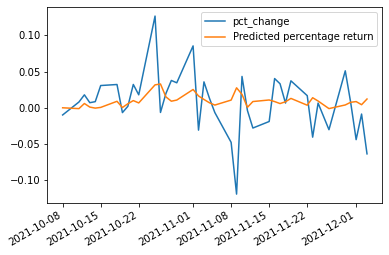

In [59]:
results.plot()

In [60]:
# Statistical analysis of model
mse = mean_squared_error(results["pct_change"], results["Predicted percentage return"])
rmse = np.sqrt(mse)
r2 = r2_score(results['pct_change'], results['Predicted percentage return'])
print(f"R2 score: {r2}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")
results.head(10)

R2 score: -0.00208005938291822
Out-of-Sample Root Mean Squared Error (RMSE): 0.040795857428110496


,pct_change,Predicted percentage return
2021-10-08,-0.010112,-0.000185
2021-10-11,0.007835,-0.001341
2021-10-12,0.017760,0.005754
2021-10-13,0.006876,0.000790
2021-10-14,0.008308,-0.000637
2021-10-15,0.030635,0.000348
2021-10-18,0.032073,0.008790
2021-10-19,-0.006838,0.000219
2021-10-20,0.001886,0.005400
2021-10-21,0.032121,0.009806


In [61]:
# The End